In [ ]:
!unzip /content/drive/MyDrive/emo_dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/emo_dataset/Actor_03/03-02-02-01-02-02-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-02-02-01-01-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-02-02-01-02-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-02-02-02-01-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-02-02-02-02-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-03-01-01-01-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-03-01-01-02-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-03-01-02-01-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-03-01-02-02-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-03-02-01-01-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-03-02-01-02-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-03-02-02-01-03.wav  
  inflating: /content/emo_dataset/Actor_03/03-02-03-02-02-02-03.wav  
  inflating: /content/emo_dataset/Actor

In [ ]:
!pip install librosa

In [ ]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/emo_dataset/Actor_02/03-01-01-01-01-01-02.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


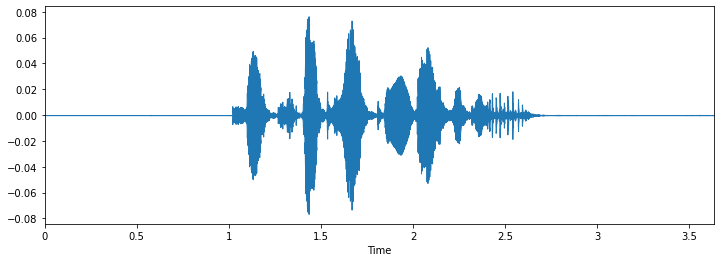

In [ ]:
% pylab inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

Feature Extraction

In [ ]:
import time
import os
path = '/content/emo_dataset'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

        feature= np.array([])
        feature=np.hstack((feature, mfccs)) 
        feature=np.hstack((feature, mel)) 

        file = int(file[7:8]) - 1

        arr = feature, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 386.93018412590027 seconds ---


In [ ]:
X, y = zip(*lst)

In [ ]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((5252, 168), (5252,))

In [ ]:
import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/drive/My Drive/SER_cnn'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [ ]:
import joblib
X = joblib.load('/content/drive/My Drive/SER_cnn/X.joblib')
y = joblib.load('/content/drive/My Drive/SER_cnn/y.joblib')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [ ]:
import numpy as np
x_train = np.expand_dims(X_train, axis=2)
x_test = np.expand_dims(X_test, axis=2)

In [ ]:
x_train.shape, x_test.shape

((4201, 168, 1), (1051, 168, 1))

Model Architecture

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.models import Model
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()



model.add(Conv1D(64, 5,padding='same',
                 input_shape=(168,1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(8))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 168, 64)           384       
_________________________________________________________________
activation_8 (Activation)    (None, 168, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 168, 64)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 42, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 42, 128)           41088     
_________________________________________________________________
activation_9 (Activation)    (None, 42, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 42, 128)          

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
ser_cnn=model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
263/263 [==============================] - 9s 32ms/step - loss: 9.1532 - accuracy: 0.1518 - val_loss: 1.6379 - val_accuracy: 0.3882
Epoch 2/200
263/263 [==============================] - 9s 35ms/step - loss: 2.8011 - accuracy: 0.2920 - val_loss: 1.4657 - val_accuracy: 0.5205
Epoch 3/200
263/263 [==============================] - 11s 41ms/step - loss: 1.6731 - accuracy: 0.4365 - val_loss: 1.3231 - val_accuracy: 0.5718
Epoch 4/200
263/263 [==============================] - 9s 35ms/step - loss: 1.3315 - accuracy: 0.5228 - val_loss: 1.2166 - val_accuracy: 0.6051
Epoch 5/200
263/263 [==============================] - 8s 31ms/step - loss: 1.2225 - accuracy: 0.5571 - val_loss: 1.1154 - val_accuracy: 0.6451
Epoch 6/200
263/263 [==============================] - 8s 32ms/step - loss: 1.1672 - accuracy: 0.5811 - val_loss: 1.0556 - val_accuracy: 0.6565
Epoch 7/200
263/263 [==============================] - 8s 32ms/step - loss: 1.0319 - accuracy: 0.6251 - val_loss: 0.9956 - val_accuracy

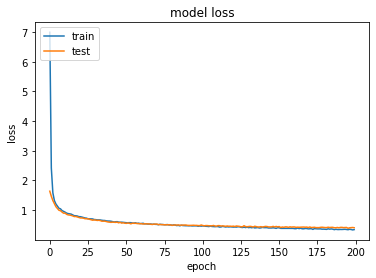

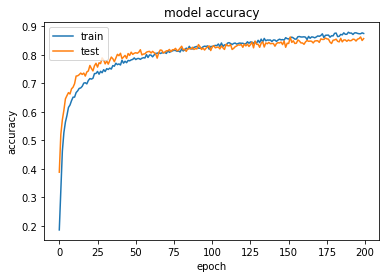

In [ ]:
plt.plot(ser_cnn.history['loss'])
plt.plot(ser_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(ser_cnn.history['accuracy'])
plt.plot(ser_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
predictions

array([1, 5, 3, ..., 5, 5, 3])

In [ ]:
y_test

array([7, 5, 3, ..., 5, 5, 3])

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

array([7, 5, 3, ..., 5, 5, 3])

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       114
           1       0.81      0.79      0.80        85
           2       0.93      0.84      0.88       164
           3       0.81      0.86      0.84       153
           4       0.88      0.88      0.88       150
           5       0.92      0.80      0.85       164
           6       0.85      0.86      0.85       108
           7       0.81      0.92      0.86       113

    accuracy                           0.86      1051
   macro avg       0.85      0.86      0.85      1051
weighted avg       0.86      0.86      0.86      1051



In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

[[104   4   0   4   0   0   2   0]
 [  8  67   0   5   0   0   2   3]
 [  3   3 137   5   7   5   1   3]
 [  7   4   1 132   0   4   1   4]
 [  1   0   5   1 132   3   4   4]
 [  1   1   3  14   5 131   4   5]
 [  2   3   0   1   4   0  93   5]
 [  1   1   1   1   2   0   3 104]]


In [ ]:
model.save('testing10_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [ ]:
new_model=keras.models.load_model('testing10_model.h5')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 168, 64)           384       
_________________________________________________________________
activation_8 (Activation)    (None, 168, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 168, 64)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 42, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 42, 128)           41088     
_________________________________________________________________
activation_9 (Activation)    (None, 42, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 42, 128)          

In [ ]:
loss, acc = new_model.evaluate(x_test, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

33/33 [==============================] - 1s 11ms/step - loss: 0.4081 - accuracy: 0.8563
Restored model, accuracy: 85.63%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
print(model.layers[-3].name)
layer_name = model.layers[-3].name
feature_layer = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)

dense_4


In [ ]:
train_data_features=feature_layer.predict(x_train,verbose=1)
print(train_data_features.shape)

132/132 [==============================] - 1s 10ms/step
(4201, 64)


In [ ]:
import pandas as pd
train_features=pd.DataFrame(data=train_data_features)
train_features.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,1.730721,3.419347,0.966815,0.587829,1.397631,-5.383400,-1.977973,2.456100,-0.923979,-3.059583,1.270119,1.507227,-2.002660,-2.282559,-1.637436,-3.354105,-0.825518,-3.230847,-2.475314,-3.673097,2.357759,-0.886446,3.585371,1.052446,-2.201297,0.694794,-0.183875,2.481121,-2.854574,1.133284,3.325087,-0.600693,0.108821,-1.217685,0.150891,-1.809973,-2.349164,0.836689,0.447141,0.814846,1.376395,0.119272,-3.995148,-1.347106,2.526771,0.524851,0.481859,0.166605,-0.466096,-0.403901,-0.270943,1.801025,-4.554010,1.139210,-3.717602,-2.103722,-4.393820,3.816770,-0.452641,0.292367,-1.342882,2.467571,1.287972,-0.002632
1,3.369763,5.937665,1.513556,-0.380205,2.758600,-11.809455,-3.499492,8.712256,-1.300004,-5.622364,2.067722,3.307996,-3.076675,-3.849944,-1.094758,-6.978169,-3.179190,-6.629305,-6.725420,-7.081150,5.555795,-4.954225,7.836266,4.473810,-4.799717,-0.449431,1.382103,5.641834,-7.661144,1.723559,6.991195,-0.724532,2.632804,0.415623,0.346906,-2.488420,-3.773760,1.216141,-0.832160,1.899095,4.292219,-2.366430,-7.207673,-2.732713,6.956163,2.051988,1.007528,0.617211,-2.922495,-1.735496,-0.257241,3.268408,-12.289784,1.875658,-12.436812,-3.680692,-9.823091,9.669388,-0.640121,-0.238707,-4.234234,4.816250,2.986238,-3.178068
2,-0.467021,4.215581,-0.369406,1.492251,0.797174,-6.882279,0.062376,5.412147,2.270225,-4.098494,-3.559465,6.637546,-5.345106,1.572046,1.785007,-4.356268,-3.749035,-3.470649,-1.482196,-6.628808,2.190774,-0.994541,1.352875,0.903568,1.154905,3.141717,-1.563424,3.354475,-0.484215,-1.264826,5.079770,-6.177777,0.448119,0.566768,-1.159446,-2.054861,-3.302216,0.693142,1.964965,4.809773,2.101755,-3.043072,-9.345404,1.986286,5.061932,-1.267332,0.164979,-1.678408,-5.193746,0.906480,-0.260225,5.284749,-10.772716,0.429290,-9.862534,-2.506185,-7.098663,5.820435,0.956336,3.001696,-4.018860,1.848569,-0.205516,0.424623
3,1.142893,2.855375,-1.947006,2.384177,1.340653,-10.335879,-3.381791,3.545570,2.924573,-4.622262,-2.236416,5.872475,-5.734030,1.701241,-2.398263,-5.015125,0.561943,-5.257614,-5.905452,-7.627436,1.895896,-0.749956,5.474682,3.121067,-1.758490,3.316283,1.673909,4.207242,-0.477944,-0.209555,7.071696,-3.462472,-0.431917,-3.449744,-3.178751,-2.913385,-6.300663,3.551293,2.620860,2.659640,0.885778,-1.462566,-8.576248,1.426769,6.938688,1.298942,-1.220408,-0.073135,-3.622145,2.656141,-1.676922,5.620917,-6.537106,-0.904034,-6.014404,-3.293417,-6.133254,7.994937,0.246187,0.947119,-5.535384,3.082551,2.839446,-0.791502
4,2.911031,3.302247,2.108405,-0.522538,-1.018652,-10.574954,-2.818000,2.851449,-0.729972,-3.021475,0.479934,3.773867,-3.969740,-2.369553,-2.186137,-4.166447,-0.513038,-2.341117,-2.355114,-3.284134,2.567906,-0.343254,2.060894,0.327239,-1.006103,1.773940,-2.090912,6.117074,-4.311502,1.164235,1.760218,-2.348744,-2.173144,-3.110807,-0.455548,-0.782324,-5.011393,1.813130,1.327506,2.996503,0.793209,0.680829,-7.029565,-1.955077,2.343216,-1.305040,-1.067263,-1.639284,-0.260406,0.669572,-1.588149,3.823305,-5.994467,3.571728,-5.295759,-1.652294,-7.274370,2.191890,2.895227,1.119784,-1.158084,0.331988,0.802293,1.450306


In [ ]:
test_data_features=feature_layer.predict(x_test,verbose=1)
print(test_data_features.shape)

33/33 [==============================] - 0s 10ms/step
(1051, 64)


In [ ]:
test_features=pd.DataFrame(data=test_data_features)
test_features.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.368505,1.128823,0.877273,1.144005,-1.558472,-9.205655,-0.761520,4.528458,2.267896,-2.758568,-1.669269,4.970150,-4.428700,0.429558,0.128247,-4.036231,-0.852120,-3.556941,-2.722211,-5.059855,4.741508,-2.980765,2.727819,1.126185,0.011458,0.580800,-1.012465,3.746049,-0.706377,-1.058249,3.024024,-2.925402,0.135739,-0.441308,-1.627672,1.003251,-2.963047,1.889280,0.300535,3.526366,0.104514,-3.204410,-6.787403,0.290204,4.721591,-1.326989,-0.569014,-1.173149,-5.344987,-0.259152,-0.949755,4.337673,-7.656859,1.062318,-7.061196,-0.366524,-6.231084,5.831811,1.808913,2.551961,-3.832219,-0.426833,1.473720,-1.173101
1,1.003020,3.558213,-2.016562,1.299950,0.988873,-8.120389,-3.242249,4.197176,2.709858,-3.700932,-0.779149,3.664647,-3.328606,0.609964,-1.212881,-3.808777,-0.291393,-3.184524,-4.305521,-5.606873,1.277909,-1.194455,3.647792,1.831018,-0.397809,1.083688,0.376516,3.300318,-1.274508,-0.405741,5.452947,-2.100487,0.194119,-2.680943,-1.541883,-1.602088,-4.832300,1.943585,3.089514,2.392983,1.985954,-1.385466,-6.466618,0.190454,5.515959,0.115648,-0.245179,-1.186261,-2.751118,1.371131,-1.189874,4.445635,-6.372915,-0.032593,-5.128176,-2.646035,-6.067906,5.796398,0.462564,0.930505,-3.588860,2.137801,0.994987,-0.711112
2,-0.923137,2.914708,-1.646621,1.896258,0.419018,-8.657205,-0.453159,5.369887,3.694696,-4.099275,-4.795491,7.072540,-5.189911,3.310786,1.977104,-4.883387,-2.244377,-4.100422,-2.922774,-7.484818,2.518336,-1.468597,2.127795,1.531676,1.620650,3.487992,-0.974346,3.949564,1.469182,-1.823069,5.562034,-5.847643,0.430623,-0.429463,-2.460276,-1.916439,-4.314051,1.622981,2.583040,4.785852,1.786996,-3.685184,-9.600632,2.886081,6.440632,-0.914184,-0.849008,-1.979849,-6.424698,1.486552,-0.664118,5.788004,-10.986721,-0.252951,-10.287392,-1.451280,-7.717168,7.260528,1.032117,2.654236,-5.077290,1.713996,0.412853,-0.896734
3,-0.415030,3.064605,0.884001,-0.096993,-0.336173,-7.099703,-1.353198,4.718192,1.825253,-3.430732,-1.930900,4.245440,-2.302760,0.837339,1.164001,-3.957110,-2.740932,-2.239578,-2.743599,-4.352905,3.650622,-2.887953,2.442775,2.498269,-1.501853,1.860836,-1.383054,3.747358,-2.615140,-0.617540,2.477729,-3.653758,1.449381,0.665578,-1.548399,-0.361439,-2.977838,1.919912,-0.584198,1.543359,0.912980,-1.692920,-4.684674,-0.253361,2.263371,0.417301,-1.174422,0.156007,-3.418319,-1.431352,-1.474603,1.936538,-7.988424,2.025813,-7.983524,-0.539115,-6.337722,5.514747,1.755157,2.617151,-1.930086,1.025695,0.092219,-1.302841
4,3.403467,2.219309,0.948659,2.279325,0.643228,-15.916760,-2.090516,4.148281,-0.102924,-3.127237,1.340909,7.863978,-6.540213,-2.630541,-3.337029,-3.784065,0.921291,-6.418059,-4.030831,-7.887650,4.080499,-1.261997,7.330146,1.434789,-4.494761,2.823944,-0.606759,8.062712,-7.353220,-1.795445,6.582505,-3.870587,-1.389607,-1.049129,-3.418774,-3.039040,-6.712356,5.461592,-1.188634,2.341511,0.123225,-2.981530,-9.086394,-3.634760,2.432214,-0.297161,-3.481100,-1.233709,-4.683112,-0.586684,-4.827178,3.584652,-10.790593,5.119675,-10.615672,0.779052,-12.449076,7.597645,2.969339,1.437847,-5.288099,3.450106,2.908308,0.551100


In [ ]:
base_knn = KNeighborsClassifier(n_neighbors = 8)
# Fit the classifier to the data
base_knn.fit(CNN_trained_features, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [ ]:
base_knn_predictions=base_knn.predict(test_features)
print(base_knn_predictions.shape)

(1051,)


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, base_knn_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       114
           1       0.70      0.84      0.76        85
           2       0.84      0.79      0.82       164
           3       0.81      0.80      0.81       153
           4       0.89      0.89      0.89       150
           5       0.84      0.80      0.82       164
           6       0.87      0.84      0.85       108
           7       0.86      0.85      0.85       113

    accuracy                           0.83      1051
   macro avg       0.83      0.84      0.83      1051
weighted avg       0.84      0.83      0.83      1051

